In [ ]:
#import all required libraries 
import numpy as np
import pandas as pd 
from matplotlib import pyplot as plt

In [ ]:
#import data 
data = pd.read_csv('train.csv') #in this file, 1 row = 1 image
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#converting to a NumPy matrix to complete linear algebra operations
data = np.array(data)
m, n = data.shape #m = number of images (42,000), n is pixels+1 (785)
#shuffling data to prevent the network from "memorizing" the order of the data
np.random.shuffle(data)

#dev batch
#taking the first 1000 images and transposing them -> turns "Rows=Images" into "Rows=Pixels"
data_dev = data[0:1000].T
Y_dev = data_dev[0] #the "answer key" for each of these 1000 images
X_dev = data_dev[1:n] #the "input layer" (the pixels)
X_dev = X_dev/255 #squish 0-255 to 0-1 (activation range)

#training batch - do the same for the remaining 41,000 images
data_train = data[1000:m].T
Y_train = data_train[0] #the correct labels
X_train = data_train[1:n] #the input pixels
X_train = X_train/255



In [ ]:
X_train[:, 0].shape #confirming that the first column has 784 pixels 

(784,)

In [ ]:
#initialize params 
def init_params(): 
    #W1: weights connecting Input (784) to hidden layer (10)
    #this means: every one of the 10 hidden neurons needs a weight for all the 784 pixels - that is 10 x 784 = 7840 connections
    #subtracting 0.5 to get weights btwn -0.5 and 0.5 (bc if all the weights are positive (0 to 1), every neuron will likely fire very strongly right at the start)
    W1 = np.random.rand(10, 784) - 0.5 
    b1 = np.random.rand(10, 1) - 0.5 #each of the 10 neurons have their own bias
    W2 = np.random.rand(10, 10) - 0.5 #weights connecting hidden layer (10) to output (10)
    b2 = np.random.rand(10,1) - 0.5
    return W1, b1, W2, b2

#define ReLU
def ReLU(Z):
    return np.maximum(0,Z)  #represents same idea as ReLU piecewise function

#define Softmax
def softmax(Z): # softmax takes raw scores of 10 output neurons and turns them into probabilities that sum to 100%
    A = np.exp(Z)
    return A / np.sum(A, axis=0) #axis=0 ensures we sum down the columns
    

#forward propagation
def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1 #calculate weighted sum for first hidden layer 
    A1 = ReLU(Z1) #get activation of each neuron within first hidden layer using ReLU 
    Z2 = W2.dot(A1) + b2 #apply the same process to get the weighted sum of output layer (this time we are using activation of each neuron in previous layer - A1)
    A2 = softmax(Z2) #apply softmax to get probability for activation of each neuron for output layer 
    return Z1, A1, Z2, A2
    
#before completing backprop we need to one hot encode Y
def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max()+1)) #create a grid of zeros
    one_hot_Y[np.arange(Y.size), Y] = 1 #put a "1" in the correct digit's spot - e.g. if the image is a 3 we want the 4th neuron to be at max brightness -> [0,0,0,1,0,0,...0]
    one_hot_Y = one_hot_Y.T #flipping so that each column is an example (matches our layer orientation)
    return one_hot_Y

#slope of the activation function.If the neuron fired (Z > 0), the slope is 1. If not, it's 0. We need this for the 'Chain Rule' to know how much to nudge
def deriv_ReLU(Z):
    return Z > 0 #for booleans - true converts to 1, while false converts to 0

#backpropagation
def back_prop(Z1, A1, Z2, A2, W2, X, Y):
    m = Y.size #gets the number of training examples (batch size)
    one_hot_Y = one_hot(Y) #this is our desired output (compare our guess, A2 against this value)
    dZ2 = A2 - one_hot_Y #error of output layer ("nudge to the activation")
    dW2 = 1/m * dZ2.dot(A1.T) #calculates how to change the weights btwn the hidden layer and output (weight's influence depends on the activation of the neuron it comes from - A1)
    #axis=1 sums rows; keepdims=True keeps it as (10,1) instead of (10,)
    db2 = 1 / m * np.sum(dZ2, axis=1, keepdims=True)  #the average nudge for the biases (don't have "previous activation" attached to them - so sum the raw error)
    
    #note: here, 1/m is the avg part of the mean squared error (bc we are dealing with 41,000 training examples here), while the second half of each of those eqns are just the "nudge calculation (aka backprop)"
    dZ1 = W2.T.dot(dZ2) * deriv_ReLU(Z1) #this is the idea of the chain rule - we are backpropagating to the hidden layer (We take the output error (dZ2), multiply by the weights (W2.T) to see how much the hidden layer contributed to the mistake, and then multiply by the derivative of the activation function (deriv_ReLU))
    dW1 = 1 / m * dZ1.dot(X.T) #nudges for weights btwn the input (pixels) and hidden layer
    db1 = 1 / m * np.sum(dZ1, axis=1, keepdims=True) #avg nudge for the hidden layer biases 
    
    return dW1, db1, dW2, db2 #retusn the "Gradient" - the direction of the "steepest descent" down the cost function/cost hill

#update params - alpha is the learning rate AKA step size 
def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1 #subtracting to keep going down the cost hill to find the minimum error (applies to all other lines in this function)
    W2 = W2 - alpha * dW2
    b1 = b1 - alpha * db1
    b2 = b2 - alpha * db2
    return W1, b1, W2, b2
    

In [ ]:
def get_predictions(A2):
    #idea: look at the 10 output neurons. Which one is 'brightest'?
    return np.argmax(A2, 0) #finding the index (0-9) of the highest number in the output layer -> [0.1,0.05, 0.8,...] - argmax picks index 2

def get_accuracy(predictions, Y): #comparing the brightest neuron to the actual label from the CSV
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X,Y, iterations,alpha):
    W1, b1, W2, b2 = init_params() #start at a random spot on the cost hill/function
    for i in range(iterations): #repeat the learning process
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X) #"think" (process the image and make a guess)
        dW1, db1, dW2, db2 = back_prop(Z1, A1, Z2, A2, W2, X, Y) #network looks at the "answer key" (Y) to see how wrong its "think" was and find the nudges
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha) #step down
        #to check our progress, for every 10th iteration we will print the iteration we are on and the accuracy 
        if (i % 10 == 0):
            print('Iteration: ', i)
            print('Accuracy: ', get_accuracy(get_predictions(A2), Y))
    #the training loop is over. We return the final version of the weights and biases, which have been 'nudged' over many iterations to reside 
    #in a low-cost area of the landscape. These are our 'trained' parameters.
    return W1, b1, W2, b2   
        

In [ ]:
W1, b1, W2, b2 = gradient_descent(X_train, Y_train, 500, 0.1) 

Iteration:  0
[8 8 8 ... 0 8 8] [5 6 1 ... 1 4 5]
Accuracy:  0.07097560975609755
Iteration:  10
[7 8 1 ... 1 4 6] [5 6 1 ... 1 4 5]
Accuracy:  0.24751219512195122
Iteration:  20
[7 8 1 ... 1 4 6] [5 6 1 ... 1 4 5]
Accuracy:  0.3643658536585366
Iteration:  30
[3 8 1 ... 1 4 6] [5 6 1 ... 1 4 5]
Accuracy:  0.42990243902439024
Iteration:  40
[3 8 1 ... 1 4 6] [5 6 1 ... 1 4 5]
Accuracy:  0.4899512195121951
Iteration:  50
[3 8 1 ... 1 4 6] [5 6 1 ... 1 4 5]
Accuracy:  0.5428780487804878
Iteration:  60
[8 8 1 ... 1 4 6] [5 6 1 ... 1 4 5]
Accuracy:  0.5908780487804878
Iteration:  70
[8 8 1 ... 1 4 6] [5 6 1 ... 1 4 5]
Accuracy:  0.6291463414634146
Iteration:  80
[8 8 1 ... 1 4 8] [5 6 1 ... 1 4 5]
Accuracy:  0.660609756097561
Iteration:  90
[8 8 1 ... 1 4 8] [5 6 1 ... 1 4 5]
Accuracy:  0.6844634146341464
Iteration:  100
[8 8 1 ... 1 4 8] [5 6 1 ... 1 4 5]
Accuracy:  0.7053414634146341
Iteration:  110
[8 8 1 ... 1 4 8] [5 6 1 ... 1 4 5]
Accuracy:  0.7214878048780488
Iteration:  120
[8 8 1 ..

In [ ]:
def make_predictions(X, W1, b1, W2, b2): #let the network make a prediction by going through forward prop
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255 #turn vector back into a square
    plt.gray()
    plt.imshow(current_image, interpolation='nearest') #draw it on the screen
    plt.show() #display result

Prediction:  [9]
Label:  9


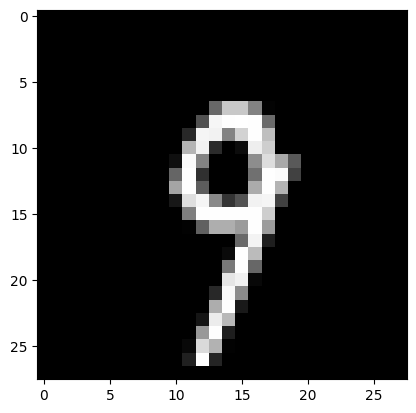

Prediction:  [1]
Label:  1


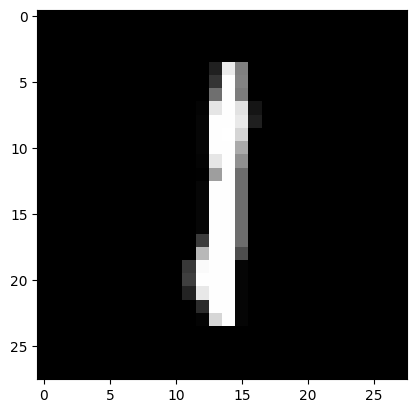

In [117]:
test_prediction(8,W1,b1,W2,b2)
test_prediction(2,W1,b1,W2,b2)


In [118]:
#checking cross-validation accuracy
dev_predictions = make_predictions(X_dev, W1, b1, W2, b2)
acc = get_accuracy(dev_predictions, Y_dev)
print(f"Accuracy: {acc * 100:.2f}%")

[4 6 1 5 5 4 1 1 0 2 3 3 3 2 8 9 8 3 7 7 1 3 9 1 5 4 3 7 6 7 7 6 4 4 6 0 7
 1 8 3 0 3 1 7 8 7 2 2 7 0 1 5 1 0 5 8 7 2 9 9 1 2 9 5 5 0 6 0 8 6 5 7 8 0
 4 4 1 8 7 0 4 6 6 9 2 9 4 6 1 5 9 7 6 7 8 4 5 9 7 0 3 0 0 6 1 8 8 5 7 9 2
 9 4 0 0 7 5 9 6 2 6 2 0 1 3 6 4 6 7 9 7 8 5 7 0 8 3 5 8 2 1 3 2 1 6 5 4 2
 0 7 8 4 7 2 2 2 0 4 6 9 5 7 3 7 7 2 4 2 2 1 9 4 9 0 4 1 0 3 2 6 7 2 9 5 5
 9 0 5 8 8 8 0 0 0 7 3 5 2 7 2 0 3 2 8 0 2 4 6 6 4 8 6 5 0 7 6 0 8 1 4 3 8
 4 6 7 6 0 1 2 1 7 8 8 5 5 0 0 6 8 6 6 1 1 3 1 4 6 7 3 9 9 9 2 6 4 0 6 6 4
 1 3 6 9 4 3 8 6 3 5 9 0 9 0 7 7 3 7 8 7 1 8 4 1 4 6 1 1 8 9 3 7 3 4 1 6 7
 4 0 8 0 4 3 5 1 3 5 2 7 0 4 6 2 2 1 6 1 0 6 1 8 3 9 5 3 3 3 1 5 1 8 2 9 3
 5 6 3 8 9 2 6 4 6 3 2 6 5 8 2 8 6 9 3 9 8 4 3 0 8 5 4 0 1 8 1 2 4 4 6 2 8
 1 9 8 0 6 1 1 2 6 9 1 4 4 0 3 6 5 5 3 3 1 0 0 6 3 8 4 5 6 1 7 7 1 0 1 1 6
 3 9 5 3 1 4 6 7 0 1 7 6 1 7 3 2 3 8 2 7 2 5 0 9 6 6 1 5 0 2 2 6 2 3 7 2 7
 9 7 8 6 6 1 1 4 3 4 9 9 4 2 8 0 8 0 9 5 3 6 2 2 5 5 6 7 3 4 5 7 6 3 8 8 3
 6 0 8 6 9 7 0 2 4 0 1 4 